<a href="https://colab.research.google.com/github/caliskate/ai-img-enhancement-webapp/blob/main/HF_Fine_tuning_Colorization%2BInpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installations

In [1]:
# Check Colab virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
55M	/content/sample_data
55M	/content


In [2]:
# Upgrade pip
!pip install --upgrade pip

# Install PyTorch/XLA for TPU
!pip install torch torchvision torchaudio torch_xla --extra-index-url https://storage.googleapis.com/pytorch-tpu-releases/wheels/tpuvm/torch_xla-2.8

# Upgrade Hugging Face and other dependencies
!pip install --upgrade diffusers transformers accelerate safetensors datasets huggingface_hub peft opencv-python-headless python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://storage.googleapis.com/pytorch-tpu-releases/wheels/tpuvm/torch_xla-2.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 4.5 MB/s  0:00:17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 58.7 MB/s  0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.11.0
    Uninstalling accelerate-1.11.0:
      Successfully uninstalled accelerate-1.11.0
   ━━━━━━━━━━━━

In [3]:
# Verify diffusers version
import diffusers
print(diffusers.__version__)

0.35.2


Libraries

In [4]:
import torch
# Colorizer-------------------
from diffusers import StableDiffusionPipeline
# Inpainting ---------------
from diffusers import StableDiffusionInpaintPipeline
# ----------------------------------------
from google.colab import drive
import os
from dotenv import load_dotenv
from datasets import load_dataset
from huggingface_hub import login

# Preprocessing, data handling
from sklearn.model_selection import train_test_split

# Visualizations
import cv2
from PIL import Image, ImageDraw
from IPython.display import display
import matplotlib.pyplot as plt

# Colorizer fine tuning
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from peft import LoraConfig, get_peft_model_state_dict
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
from peft import LoraConfig, get_peft_model_state_dict, get_peft_model
from torch import nn, optim
from tqdm import tqdm

# LoRA prep
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from diffusers import StableDiffusionPipeline


/usr/local/lib/python3.12/dist-packages/torch_xla/__init__.py:246: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [5]:
# Check virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
55M	/content/sample_data
55M	/content


In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Env file path
env_path = "/content/drive/MyDrive/AAI-521 Final Project/hf_login.env"
# Open env file
load_dotenv(env_path)
# Access token from environment
#hf_key = os.getenv("HF_TOKEN")

print("HF key loaded:", hf_key is not None)

# Dataset Paths

# Paths for colorization ds train/val/test img subsets
COLORIZER_DATA_ROOT = "/content/drive/MyDrive/AAI-521 Final Project/colorization_subset"
COLOR_SPLIT_DIRS = {
    "train": os.path.join(COLORIZER_DATA_ROOT, "train"),
    "val":   os.path.join(COLORIZER_DATA_ROOT, "val"),
    "test":  os.path.join(COLORIZER_DATA_ROOT, "test"),
}
# Create dataset directories
os.makedirs(COLORIZER_DATA_ROOT, exist_ok=True)
for d in COLOR_SPLIT_DIRS.values():
    os.makedirs(d, exist_ok=True)
    os.makedirs(os.path.join(d, "gray"), exist_ok=True)
    os.makedirs(os.path.join(d, "color"), exist_ok=True)

COLORIZER_MODEL_OUTPUT = "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models"
# Path to colorizer test image
colorize_image_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/colorize_ex1.png"
# Ensure test_images folder exists
os.makedirs("/content/drive/MyDrive/AAI-521 Final Project/test_images", exist_ok=True)

# -------------------------
# Model 3. Image Colorization
# -------------------------
colorizer_base_model = "runwayml/stable-diffusion-v1-5"
# Load Base Model - SD-1-5
colorizer_base_pipe = StableDiffusionPipeline.from_pretrained(
    colorizer_base_model,
    dtype=torch.float32
)
IMG_SIZE = (512, 512)   # Resolution must be divisible by 8 (SD requirement)
FINE_MODEL_SAVE_DIR = "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models"
# Make sure it exists
os.makedirs(FINE_MODEL_SAVE_DIR, exist_ok=True)
# Subfolder for pipeline
FINE_PIPELINE_DIR = os.path.join(COLORIZER_MODEL_OUTPUT, "colorizer_pipeline")
os.makedirs(FINE_PIPELINE_DIR, exist_ok=True)

HF key loaded: True


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Keyword arguments {'dtype': torch.float32} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
# Check virtual memory
!du -h --max-depth=1 /content

140K	/content/.config
173M	/content/drive
55M	/content/sample_data
228M	/content


In [9]:
colorize_test_image = Image.open(colorize_image_path).convert("RGB")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AAI-521 Final Project/test_images/colorize_ex1.png'

Load COCO dataset

In [10]:
#coco_ds = load_dataset("detection-datasets/coco")
coco_ds = load_dataset(
    "detection-datasets/coco",
    split="train[:3000]"   # download only 3000 items
)

README.md:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00040-67e35002d15215(…):   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00001-of-00040-2c2b33b9504aa8(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00002-of-00040-58e30306870b1d(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00003-of-00040-a77e00648e4239(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00004-of-00040-1df1755d6f7c9b(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00005-of-00040-29ccfc8f52cfc9(…):   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00006-of-00040-76f2d663d51dca(…):   0%|          | 0.00/483M [00:00<?, ?B/s]

data/train-00007-of-00040-797508421c59b9(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00008-of-00040-7ad10a6d6b442e(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00009-of-00040-edc6018bb7abee(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00010-of-00040-068d922af9742c(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00011-of-00040-2cf010e9592da4(…):   0%|          | 0.00/483M [00:00<?, ?B/s]

data/train-00012-of-00040-e26d7a054b1f8c(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00013-of-00040-00a967ab3e2568(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00014-of-00040-4f6a348405f372(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00015-of-00040-ae8972f628750c(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00016-of-00040-37711297359438(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00017-of-00040-e2f542f29ca613(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00018-of-00040-3650ae2c12a832(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00019-of-00040-f262669c6302eb(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00020-of-00040-d2763ce5e7ab09(…):   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00021-of-00040-fb98d35ab4e6ca(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00022-of-00040-c4f90a7435af52(…):   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00023-of-00040-31db5fa16e24d3(…):   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00024-of-00040-786ee9123ad04e(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00025-of-00040-369c096f8c7d7a(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00026-of-00040-709cf1a409a269(…):   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00027-of-00040-c99041dbf75151(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00028-of-00040-5e11f3d596cb0d(…):   0%|          | 0.00/480M [00:00<?, ?B/s]

data/train-00029-of-00040-988997614786b5(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00030-of-00040-497df2d4082da4(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00031-of-00040-541a6ccf9f2109(…):   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00032-of-00040-659aee4f72e8f5(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00033-of-00040-0074f368f67338(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00034-of-00040-edcd109018ecaf(…):   0%|          | 0.00/481M [00:00<?, ?B/s]

data/train-00035-of-00040-c8fd4fb1bb9311(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00036-of-00040-5d6d294fbed2af(…):   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00037-of-00040-cb1276b8824445(…):   0%|          | 0.00/479M [00:00<?, ?B/s]

data/train-00038-of-00040-15a5fd14791741(…):   0%|          | 0.00/482M [00:00<?, ?B/s]

data/train-00039-of-00040-f1a97fa690638b(…):   0%|          | 0.00/474M [00:00<?, ?B/s]

data/val-00000-of-00002-c4f2e391ee4aba11(…):   0%|          | 0.00/404M [00:00<?, ?B/s]

data/val-00001-of-00002-7af5414a3b178949(…):   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117266 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/4952 [00:00<?, ? examples/s]

In [11]:
# Full COCO dataset
coco_ds

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 3000
})

# Denoiser algorithm

In [12]:
# Denoiser Algorithm

# ---------------------------------------------------------
# DIFFUSION-BASED IMAGE DENOISING (Option D)
# ---------------------------------------------------------
# This uses a dedicated stable diffusion img2img model:
#denoiser_model_id = "stabilityai/stable-diffusion-2-1"
denoiser_model_id = "runwayml/stable-diffusion-v1-5"


# NOTE:
# If you want to reuse your existing colorizer model instead,
# simply set:
#    denoiser_model_id = colorizer_base_model
# This lets you share weights between colorization and denoising.
# ---------------------------------------------------------

from diffusers import StableDiffusionImg2ImgPipeline
import torch

print(f"Loading diffusion denoising pipeline: {denoiser_model_id}")

denoise_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    denoiser_model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None   # often needed for img2img in local environments
)
denoise_pipe = denoise_pipe.to("cuda" if torch.cuda.is_available() else "cpu")


def diffusion_denoise(
    pil_image,
    prompt="clean, sharp, detailed image, no noise, no grain",
    negative_prompt="grain, noise, artifacts, blur",
    denoise_strength=0.25,        # Lower = closer to original; higher = stronger denoising
    guidance_scale=7.0,
    num_inference_steps=25
):
    """
    Perform diffusion-based denoising using Stable Diffusion img2img.
    The image is slightly "nudged" toward a clean version of itself.
    """
    print("Running diffusion denoising...")

    # Ensure correct size for the diffusion pipeline
    image_resized = pil_image.resize(IMG_SIZE)

    result = denoise_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image_resized,
        strength=denoise_strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
    )

    denoised_image = result.images[0]

    print("Denoising complete.")
    return denoised_image


Loading diffusion denoising pipeline: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Running diffusion denoising...


  0%|          | 0/8 [00:00<?, ?it/s]

Denoising complete.


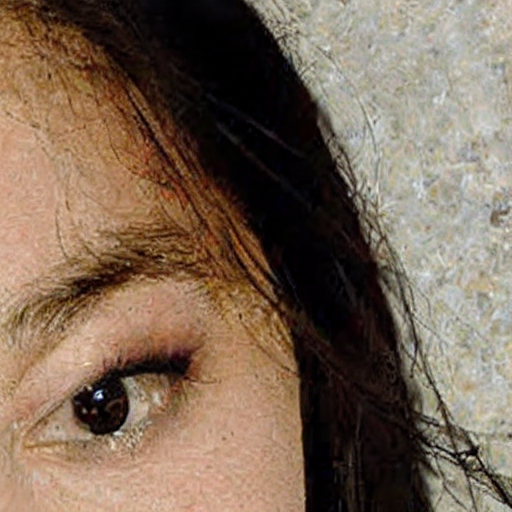

In [13]:
# Test the diffusion denoiser
test_noisy_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/noisy.jpeg"
test_noisy = Image.open(test_noisy_path).convert("RGB")

denoised = diffusion_denoise(
    test_noisy,
    denoise_strength=0.35,
    prompt="high-quality clean image, sharp edges"
)

display(denoised)
denoised.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/denoised_output.png")


# Super Resolution

In [21]:
# ---------------------------------------------------------
# SUPER-RESOLUTION ALGORITHM (Swin2SR)
# ---------------------------------------------------------
# These models ARE compatible with Diffusers:
#   caidas/swin2sr-classical-sr-x2-64
#   caidas/swin2sr-classical-sr-x4-64
#   caidas/swin2sr-classical-sr-x8-64
# ---------------------------------------------------------

import torch
import numpy as np
from PIL import Image
import requests

from transformers import AutoImageProcessor, Swin2SRForImageSuperResolution

processor = AutoImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")

url = "https://huggingface.co/spaces/jjourney1125/swin2sr/resolve/main/samples/butterfly.jpg"
image = Image.open(requests.get(url, stream=True).raw)
# prepare image for the model
inputs = processor(image, return_tensors="pt")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)
output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
# you can visualize `output` with `Image.fromarray`
pil_img = Image.fromarray(output, mode='RGB')
pil_img.show()



`self.pad_size` attribute is deprecated and will be removed in v5. Use `self.size_divisor` instead
/tmp/ipython-input-2242217879.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(output, mode='RGB')


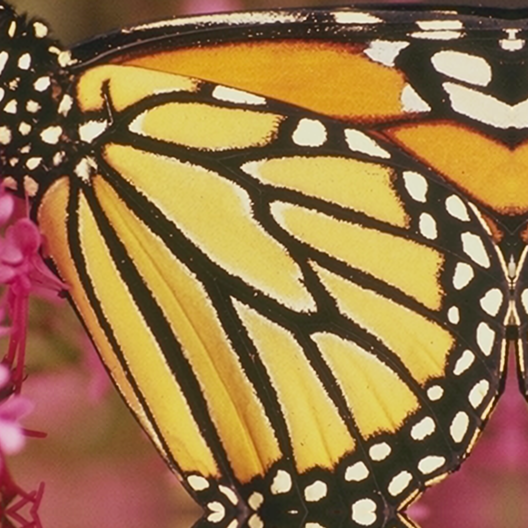

In [24]:
pil_img.show()
output_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/superres_output.png"
pil_img.save(output_path)
display(pil_img)

In [ ]:
# Test the super-resolution function
test_img_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/lowres.jpg"
test_lowres = Image.open(test_img_path).convert("RGB")

sr_result = super_resolve(test_lowres, upscale=4)

display(sr_result)
sr_result.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/superres_output.png")


# Filter COCO ds for 1500 color images

In [ ]:
# Confirm color
def is_color(pil_img):
    if pil_img.mode != "RGB":
        return False
    r, g, b = pil_img.split()
    return not (r == g == b)

color_images = []
max_needed = 1500

# Only use existing splits: train and val
for split in ["train", "val"]:
    for row in coco_ds[split]:

        img = row["image"]  # already a PIL image

        try:
            img = img.convert("RGB")
        except:
            continue

        if not is_color(img):
            continue

        color_images.append(img)

        if len(color_images) >= max_needed:
            break

    if len(color_images) >= max_needed:
        break

len(color_images)

# Create COCO colorization train, test, val subsets

In [ ]:
# Make gray, color img pairs

pairs = []  # (gray, color)

for img in color_images:
    # Resize color image
    color_resized = img.resize(IMG_SIZE, resample=Image.LANCZOS)

    # Convert to grayscale -> back to RGB for 3-channel input
    gray = color_resized.convert("L").convert("RGB")

    pairs.append((gray, color_resized))

len(pairs)
print('Splitting datasets for train, val, test...')
# Split the subset pairs
train_pairs, temp_pairs = train_test_split(pairs, test_size=0.30, random_state=42)
val_pairs, test_pairs   = train_test_split(temp_pairs, test_size=0.50, random_state=42)

print(f'Dataset images count (train/val/test): {len(train_pairs), len(val_pairs), len(test_pairs)}')
print('Saving images (train/val/test)...')

# Save the subset pairs
for split_name, split_pairs in [
    ("train", train_pairs),
    ("val", val_pairs),
    ("test", test_pairs),
]:
    out_dir = COLOR_SPLIT_DIRS[split_name]

    gray_dir = os.path.join(out_dir, "gray")
    color_dir = os.path.join(out_dir, "color")

    os.makedirs(gray_dir, exist_ok=True)
    os.makedirs(color_dir, exist_ok=True)

    for i, (gray_img, color_img) in enumerate(split_pairs):
        gray_img.save(os.path.join(gray_dir, f"{i:05d}.png"))
        color_img.save(os.path.join(color_dir, f"{i:05d}.png"))

# Visualize Colorization subset images

In [ ]:
splits = ["train", "val", "test"]

for split_name in splits:
    gray_dir = os.path.join(COLOR_SPLIT_DIRS[split_name], "gray")
    color_dir = os.path.join(COLOR_SPLIT_DIRS[split_name], "color")

    # Get first 9 images
    image_files = sorted(os.listdir(color_dir))[:9]

    # Read gray and color images
    gray_images = [cv2.resize(cv2.imread(os.path.join(gray_dir, f), cv2.IMREAD_GRAYSCALE), (128,128))
                   for f in image_files]
    color_images = [cv2.resize(cv2.imread(os.path.join(color_dir, f)), (128,128))
                    for f in image_files]

    # Plot
    plt.figure(figsize=(10, 8))
    plt.suptitle(f"Colorization {split_name.capitalize()} Images (Gray | Color)", fontsize=16)

    for i in range(9):
        # Gray image
        plt.subplot(3, 6, 2*i+1)  # 2 columns per image
        plt.imshow(gray_images[i], cmap='gray')
        plt.axis('off')

        # Color image (BGR -> RGB)
        plt.subplot(3, 6, 2*i+2)
        plt.imshow(cv2.cvtColor(color_images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Preprocessing
 -  Resize to ensure width and height are divisible by 8
 -  Prepare resized 3 channel img, SD expects 3 channels


(StableDiffusion requirements)

In [ ]:
# Image resize
width, height = colorize_test_image.size
new_width = width - (width % 8)
new_height = height - (height % 8)
image_resized = colorize_test_image.resize((new_width, new_height))

# Prepare resized 3 channel img
image_resized = image_resized.convert("RGB")  # SD expects 3 channels
display(image_resized)

# Colorization Base model pipeline image:

In [ ]:
# Run colorization on the resized image
output = colorizer_base_pipe(
    prompt="colorize the grayscale image",
    image=image_resized,
    strength=0.75,  # (Default 0.8, 0 = almost identical to input, 1 = mostly generated from scratch
    guidance_scale=5, # (Default 7.5, Low 1-3, high 15-30+) How strongly the model follows the prompt (higher = more adherence)
    num_inference_steps= 70,  # (50 default) Number of denoising steps for generation (more steps = finer details, slower)
    ).images[0]

display(output)
output.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/output_colorize_demo2.png")

# Colorizer Fine-Tuning Preparation
-  Create HF DS for fine tuning

In [ ]:
transform = T.Compose([
    T.Resize((512, 512)),        # match your training size
    T.ToTensor(),                 # convert to [0,1] tensor
])

class ColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_files = sorted(os.listdir(gray_dir))
        self.color_files = sorted(os.listdir(color_dir))
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.transform = transform

    def __len__(self):
        return len(self.gray_files)

    def __getitem__(self, idx):
        gray_img = Image.open(os.path.join(self.gray_dir, self.gray_files[idx])).convert("RGB")
        color_img = Image.open(os.path.join(self.color_dir, self.color_files[idx])).convert("RGB")

        if self.transform:
            gray_img = self.transform(gray_img)
            color_img = self.transform(color_img)

        return {"gray": gray_img, "color": color_img}

train_dataset = ColorizationDataset(
    os.path.join(COLORIZER_DATA_ROOT, "train", "gray"),
    os.path.join(COLORIZER_DATA_ROOT, "train", "color"),
    transform=transform
)

val_dataset = ColorizationDataset(
    os.path.join(COLORIZER_DATA_ROOT, "val", "gray"),
    os.path.join(COLORIZER_DATA_ROOT, "val", "color"),
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2)


# Preparing UNet for LoRA

Identifies attention layers in the UNet.

Created a LoRAAttnProcessor for each layer.

Attached processors to the UNet, ensuring counts matched.

In [ ]:
# --- START MODIFIED LoRA SETUP ---
# Initialize your pipeline
# colorizer_base_pipe = StableDiffusionPipeline.from_pretrained(...) #
unet = UNet2DConditionModel.from_pretrained(colorizer_base_model, subfolder="unet")
vae = AutoencoderKL.from_pretrained(colorizer_base_model, subfolder="vae")
text_encoder = CLIPTextModel.from_pretrained(colorizer_base_model, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(colorizer_base_model, subfolder="tokenizer")
scheduler = PNDMScheduler.from_pretrained(colorizer_base_model, subfolder="scheduler")

colorizer_base_pipe = StableDiffusionPipeline(vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet, scheduler=scheduler, safety_checker=None, feature_extractor=None)

# 1. Define the LoraConfig
# The `target_modules` specify which layers to apply LoRA to.
# Commonly targeted attention layers are "to_k", "to_q", "to_v", and "to_out.0".
lora_config = LoraConfig(
    r=8, # LoRA rank, can be adjusted
    lora_alpha=8, # Alpha value
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    init_lora_weights="gaussian"
)

# 2. Wrap the UNet with PEFT's get_peft_model
# This automatically injects the LoRA layers without manual iteration.
colorizer_base_pipe.unet = get_peft_model(colorizer_base_pipe.unet, lora_config)

# 3. Print the trainable parameters to confirm the PEFT setup
# Only the new LoRA layers should be trainable.
colorizer_base_pipe.unet.print_trainable_parameters()
print("UNet is LoRA-ready with PEFT.")
# --- END MODIFIED LoRA SETUP ---

# Fine tune with LoRA
  - with text embedding "colorize the grayscale image"

Text embeddings are not TPU compatible with diffusers v0.35.2

In [ ]:
# Move models to device
device = "cuda" if torch.cuda.is_available() else "cpu"
unet = colorizer_base_pipe.unet.to(device)
vae = colorizer_base_pipe.vae.to(device)
unet.train()
vae.eval()

optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Accuracy function
def color_accuracy(pred, target, threshold=0.01):
    mse_per_pixel = ((pred - target) ** 2).mean(dim=(1,2,3))
    return (mse_per_pixel < threshold).float().mean().item()

# Early stopping setup
patience = 2
bad_epochs = 0
best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0

    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        x = batch["gray"].to(device)
        y = batch["color"].to(device)
        B = x.size(0)

        optimizer.zero_grad()

        with torch.no_grad():
            x_latent = vae.encode(x / 255.0).latent_dist.sample() * 0.18215
            y_latent = vae.encode(y / 255.0).latent_dist.sample() * 0.18215

        # Text embeddings
        encoder_hidden_states = None
        if hasattr(colorizer_base_pipe, "text_encoder"):
            prompt = ["colorize the grayscale image"] * B
            input_ids = colorizer_base_pipe.tokenizer(
                prompt, return_tensors="pt", padding="max_length", truncation=True
            ).input_ids.to(device)
            with torch.no_grad():
                encoder_hidden_states = colorizer_base_pipe.text_encoder(input_ids)[0]

        timestep = torch.tensor([1]*B, device=device)
        pred_latent = unet(x_latent, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

        loss = criterion(pred_latent, y_latent)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * B
        train_acc += color_accuracy(pred_latent, y_latent) * B

    # Average over dataset
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    val_loss, val_acc = 0, 0
    unet.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch["gray"].to(device)
            y = batch["color"].to(device)
            B = x.size(0)

            x_latent = vae.encode(x / 255.0).latent_dist.sample() * 0.18215
            y_latent = vae.encode(y / 255.0).latent_dist.sample() * 0.18215

            encoder_hidden_states = None
            if hasattr(colorizer_base_pipe, "text_encoder"):
                input_ids = colorizer_base_pipe.tokenizer(
                    ["colorize the grayscale image"]*B, return_tensors="pt", padding="max_length", truncation=True
                ).input_ids.to(device)
                encoder_hidden_states = colorizer_base_pipe.text_encoder(input_ids)[0]

            timestep = torch.tensor([1]*B, device=device)
            pred_latent = unet(x_latent, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

            val_loss += criterion(pred_latent, y_latent).item() * B
            val_acc += color_accuracy(pred_latent, y_latent) * B

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    unet.train()

    print(f"Epoch {epoch+1}/{num_epochs} → "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        bad_epochs = 0
        # Save best UNet and full pipeline
        torch.save(colorizer_base_pipe.unet.state_dict(), os.path.join(FINE_MODEL_SAVE_DIR, "best_unet.pth"))
        colorizer_base_pipe.save_pretrained(FINE_PIPELINE_DIR)
        print("Saved best model.")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

## Fine tuned colorizer - performance

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


# Plot learning curves
epochs_range = range(1, len(train_losses)+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, marker='o', label='Train Acc')
plt.plot(epochs_range, val_accs, marker='o', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

psnr_list, ssim_list = [], []

unet.eval()
with torch.no_grad():
    for batch in val_loader:
        x = batch["gray"]
        y = batch["color"]

        B = x.size(0)

        x_latent = vae.encode(x / 255.0).latent_dist.sample() * 0.18215
        y_latent = vae.encode(y / 255.0).latent_dist.sample() * 0.18215

        encoder_hidden_states = None
        if hasattr(colorizer_base_pipe, "text_encoder"):
            input_ids = colorizer_base_pipe.tokenizer(
                ["colorize the grayscale image"]*B,
                return_tensors="pt",
                padding="max_length",
                truncation=True
            ).input_ids
            encoder_hidden_states = colorizer_base_pipe.text_encoder(input_ids)[0]

        timestep = torch.tensor([1]*B)
        pred_latent = unet(x_latent, timestep=timestep, encoder_hidden_states=encoder_hidden_states).sample

        # Decode to RGB images
        pred_rgb = vae.decode(pred_latent / 0.18215).sample.clamp(0,1)
        y_rgb = y / 255.0

        # Compute metrics per image
        for i in range(B):
            pred_img = pred_rgb[i].permute(1,2,0).cpu().numpy()
            target_img = y_rgb[i].permute(1,2,0).cpu().numpy()

            psnr_list.append(psnr(target_img, pred_img, data_range=1.0))
            ssim_list.append(ssim(target_img, pred_img, multichannel=True, data_range=1.0))

print(f"Average PSNR: {sum(psnr_list)/len(psnr_list):.2f}")
print(f"Average SSIM: {sum(ssim_list)/len(ssim_list):.4f}")


## Colorizer Fine tuned -  previous test image

In [ ]:
# Load your fine-tuned pipeline
ft_col_pipe = StableDiffusionPipeline.from_pretrained(
    "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models/colorizer_pipeline",
    torch_dtype=torch.float16
)


# Run colorization on the resized image
output = ft_col_pipe(what
    prompt="colorize the grayscale image",
    image=image_resized,
    strength=0.75,        # 0 = keep original, 1 = mostly generated
    guidance_scale=5,      # how strongly model follows prompt
    num_inference_steps=70 # more steps = finer details
).images[0]

display(output)
output.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/output_colorize_demo-f-t.png")


## Colorizer Fine tuned -  test set image

In [ ]:
# Load the fine-tuned pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models/colorizer_pipeline",
    torch_dtype=torch.float16
)

# Load LoRA weights
pipe.unet.load_state_dict(
    torch.load("/content/drive/MyDrive/AAI-521 Final Project/fine_tuned_models/unet_lora.pth")
)

# --- Load test images ---
gray_test_dir = os.path.join(COLOR_SPLIT_DIRS["test"], "gray")
color_test_dir = os.path.join(COLOR_SPLIT_DIRS["test"], "color")

test_files = sorted(os.listdir(gray_test_dir))[:9]  # pick first 9 for display

gray_images = [Image.open(os.path.join(gray_test_dir, f)).convert("RGB") for f in test_files]
true_color_images = [Image.open(os.path.join(color_test_dir, f)).convert("RGB") for f in test_files]

# --- Colorize using pipeline ---
predicted_colors = []
for gray_img in gray_images:
    # LoRA fine-tuned colorizer expects 3-channel grayscale input
    pred = pipe(prompt="", image=gray_img).images[0]
    predicted_colors.append(pred)

# --- Display results ---
plt.figure(figsize=(12, 8))
for i in range(len(test_files)):
    # Gray input
    plt.subplot(3, 3, i+1)
    plt.imshow(gray_images[i].convert("L"), cmap="gray")
    plt.axis("off")
    plt.title("Gray Input")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(len(test_files)):
    # Predicted color img
    plt.subplot(3, 3, i+1)
    plt.imshow(predicted_colors[i])
    plt.axis("off")
    plt.title("Predicted Color Image")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(len(test_files)):
    # True color img
    plt.subplot(3, 3, i+1)
    plt.imshow(true_color_images[i])
    plt.axis("off")
    plt.title("True Color Image")

plt.tight_layout()
plt.show()


# Model 4. Image Inpainting

In [ ]:
# -------------------------
# Model 4. Image Inpainting
# -------------------------

# Load pre-trained inpainting model
inpainting_model = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting"
)

# Recommended dataset (open-source)
# MS COCO, Paris StreetView, or Places2
# Create masks for missing/damaged regions
# https://places2.csail.mit.edu/
# https://cocodataset.org/#home

# Example: preprocessing images for inpainting
# Generate masks with random or structured missing parts
# Pair masked image with original image as target


In [ ]:


# Path to your test image
inpaint_test_image_path = "/content/drive/MyDrive/AAI-521 Final Project/test_images/inpaint_ex1.png"

inpaint_test_image = Image.open(inpaint_test_image_path).convert("RGB")

display(inpaint_test_image)
image.show()

In [ ]:
print(type(inpaint_test_image))

# Preprocessing -  Resize to ensure width and height are divisible by 8

(StableDiffusion requirement)

In [ ]:
# Resize so width and height are divisible by 8
width, height = image.size
new_width = width - (width % 8)
new_height = height - (height % 8)
inpaint_image_resized = inpaint_test_image.resize((new_width, new_height))

# Create mask for inpainting

In [ ]:
# Total dimensions
img_width, img_height = inpaint_test_image.size

# Create a black mask (0 = keep original)
mask = Image.new("RGB", (img_width, img_height), color=(0, 0, 0))

# Fractions for the mask position
vertical_start_fraction = 1/9       # fraction from top where mask starts - decrease to move top edge higher
vertical_end_fraction = 3/4.3       # fraction from top where mask ends - increase to move bottom edge lower (extend height)
horizontal_start_fraction = 1/4.2   # fraction from left where mask starts - decrease to move left edge further left, increase to move right
horizontal_end_fraction = 6/7       # fraction from left where mask ends - increase to extend right edge further right, decrease to shrink


# Calculate pixel coordinates
top = int(img_height * vertical_start_fraction)
bottom = int(img_height * vertical_end_fraction)
left = int(img_width * horizontal_start_fraction)
right = int(img_width * horizontal_end_fraction)

# Draw white rectangle covering the central third
draw = ImageDraw.Draw(mask)
draw.rectangle([left, top, right, bottom], fill=(255, 255, 255))

# Show mask overlayed on the original image
overlay = Image.blend(inpaint_test_image, mask, alpha=0.5)
display(overlay)

In [ ]:
# Inpainting prompt
prompt = "fill in the missing parts realistically"

# Run inpainting
output = inpainting_model(prompt=prompt, image=inpaint_image_resized, mask_image=mask).images[0]

# Display and save
display(output)
output.save("/content/drive/MyDrive/AAI-521 Final Project/test_images/output_inpaint_demo.png")